# Final Publication Figures

1. Late Fusion Performance
2. Ambiguity & Reaction Time Analysis (combined 2x2)
3. Feature Importance Analysis (SHAP)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
import seaborn as sns
from scipy import stats
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

TIMEFRAME = 'PRE'

# EMBC-style publication defaults
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica']
plt.rcParams['font.size'] = 9
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 11
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.linewidth'] = 0.8
sns.set_style('whitegrid')

# Modality colors (consistent across all figures that show modalities)
MOD_COLORS = {
    'Physiology': '#d62728',
    'Behavior': '#1f77b4',
    'Gaze': '#2ca02c',
    'Fusion': '#ff7f0e',
}

# Ambiguity colors (distinct palette)
AMB_COLORS = {'Low': '#06A77D', 'Medium': '#F4A261', 'High': '#E76F51'}

# RT colors (distinct from ambiguity)
RT_COLORS = {'Fast': '#5B8DB8', 'Slow': '#C75146'}

output_dir = Path('../../data/results/final_publication')
output_dir.mkdir(parents=True, exist_ok=True)

# ── Load data ──
method_df = pd.read_csv(f'../../data/results/fusion_model_results_{TIMEFRAME}/late_fusion_model_{TIMEFRAME}_method_comparison.csv')
weights_df = pd.read_csv(f'../../data/results/fusion_model_results_{TIMEFRAME}/late_fusion_model_{TIMEFRAME}_modality_weights.csv')
ambiguity_df = pd.read_csv(f'../../data/results/fusion_model_results_{TIMEFRAME}/ambiguity_group_late_fusion_{TIMEFRAME}_comparison.csv')
rt_df = pd.read_csv(f'../../data/results/fusion_model_results_{TIMEFRAME}/reaction_time_group_late_fusion_{TIMEFRAME}_comparison.csv')
shap_df = pd.read_csv(f'../../data/results/analysis_outputs_{TIMEFRAME}/shap_importance_all_{TIMEFRAME}.csv')

# Load weighted fusion summary for real SEM
fusion_summary = pd.read_csv(
    f'../../data/results/fusion_model_results_{TIMEFRAME}/late_fusion_model_{TIMEFRAME}_weighted_fusion_summary.csv')
fusion_sem = fusion_summary[fusion_summary['Metric'] == 'Accuracy_SEM']['Value'].values[0]

with open(f'../../data/results/features_{TIMEFRAME}/extracted_features_{TIMEFRAME}.pkl', 'rb') as f:
    feature_data = pickle.load(f)
merged_df = feature_data['merged_df']
physio_cols = feature_data['physio_cols']
behavior_cols = feature_data['behavior_cols']
gaze_cols = feature_data['gaze_cols']

# Extract key values
def get_acc(method):
    return method_df[method_df['Method'] == method]['Accuracy'].values[0]

# z-test helper (used across figures)
def z_test_proportions(p1, se1, p2, se2):
    z = (p1 - p2) / np.sqrt(se1**2 + se2**2)
    return 2 * (1 - stats.norm.cdf(abs(z)))

print(f"Data loaded: {len(merged_df)} trials, {merged_df['subject_id'].nunique()} subjects")
print(f"Weighted Fusion accuracy: {get_acc('Weighted Fusion'):.1%} (SEM = {fusion_sem:.4f} from LOSO CV)")

Data loaded: 12511 trials, 97 subjects
Weighted Fusion accuracy: 69.3% (SEM = 0.0133 from LOSO CV)


In [8]:
# ═══════════════════════════════════════════════════════════════════════════════
# FIGURE 1: Late Fusion Performance
# ═══════════════════════════════════════════════════════════════════════════════
# Compute per-modality SEMs via LOSO CV (not saved during original training)
# Results are cached to avoid re-running (~5 min)

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

cache_path = output_dir / 'modality_loso_accuracies.pkl'

if cache_path.exists():
    print("Loading cached per-modality LOSO accuracies...")
    with open(cache_path, 'rb') as f:
        cached = pickle.load(f)
    accs_physio_subj = cached['physiology']
    accs_behavior_subj = cached['behavior']
    accs_gaze_subj = cached['gaze']
else:
    subjects = merged_df['subject_id'].values
    y = merged_df['outcome'].values

    X_physio = SimpleImputer(strategy='mean').fit_transform(merged_df[physio_cols])
    X_behavior = SimpleImputer(strategy='mean').fit_transform(merged_df[behavior_cols])
    X_gaze = SimpleImputer(strategy='mean').fit_transform(merged_df[gaze_cols])

    def loso_subject_accuracies(X, y, subjects):
        """Run LOSO CV and return per-subject accuracies."""
        logo = LeaveOneGroupOut()
        subj_accs = []
        for train_idx, test_idx in logo.split(X, y, subjects):
            rf = RandomForestClassifier(
                n_estimators=200, max_depth=10,
                min_samples_split=20, min_samples_leaf=10,
                class_weight='balanced', random_state=42, n_jobs=-1)
            rf.fit(X[train_idx], y[train_idx])
            acc = accuracy_score(y[test_idx], rf.predict(X[test_idx]))
            subj_accs.append(acc)
        return np.array(subj_accs)

    print("Running LOSO CV for per-modality SEMs...")
    accs_physio_subj = loso_subject_accuracies(X_physio, y, subjects)
    print(f"  Physiology: {accs_physio_subj.mean():.3f} ± {stats.sem(accs_physio_subj):.4f}")
    accs_behavior_subj = loso_subject_accuracies(X_behavior, y, subjects)
    print(f"  Behavior:   {accs_behavior_subj.mean():.3f} ± {stats.sem(accs_behavior_subj):.4f}")
    accs_gaze_subj = loso_subject_accuracies(X_gaze, y, subjects)
    print(f"  Gaze:       {accs_gaze_subj.mean():.3f} ± {stats.sem(accs_gaze_subj):.4f}")

    # Save cache
    with open(cache_path, 'wb') as f:
        pickle.dump({
            'physiology': accs_physio_subj,
            'behavior': accs_behavior_subj,
            'gaze': accs_gaze_subj,
        }, f)
    print(f"Saved to {cache_path}")

print(f"  Physiology: {accs_physio_subj.mean():.3f} ± {stats.sem(accs_physio_subj):.4f}")
print(f"  Behavior:   {accs_behavior_subj.mean():.3f} ± {stats.sem(accs_behavior_subj):.4f}")
print(f"  Gaze:       {accs_gaze_subj.mean():.3f} ± {stats.sem(accs_gaze_subj):.4f}")
print("Done.")

Running LOSO CV for per-modality SEMs...
  Physiology: 0.534 ± 0.0132
  Behavior:   0.644 ± 0.0128
  Gaze:       0.542 ± 0.0125
Saved to ../../data/results/final_publication/modality_loso_accuracies.pkl
  Physiology: 0.534 ± 0.0132
  Behavior:   0.644 ± 0.0128
  Gaze:       0.542 ± 0.0125
Done.


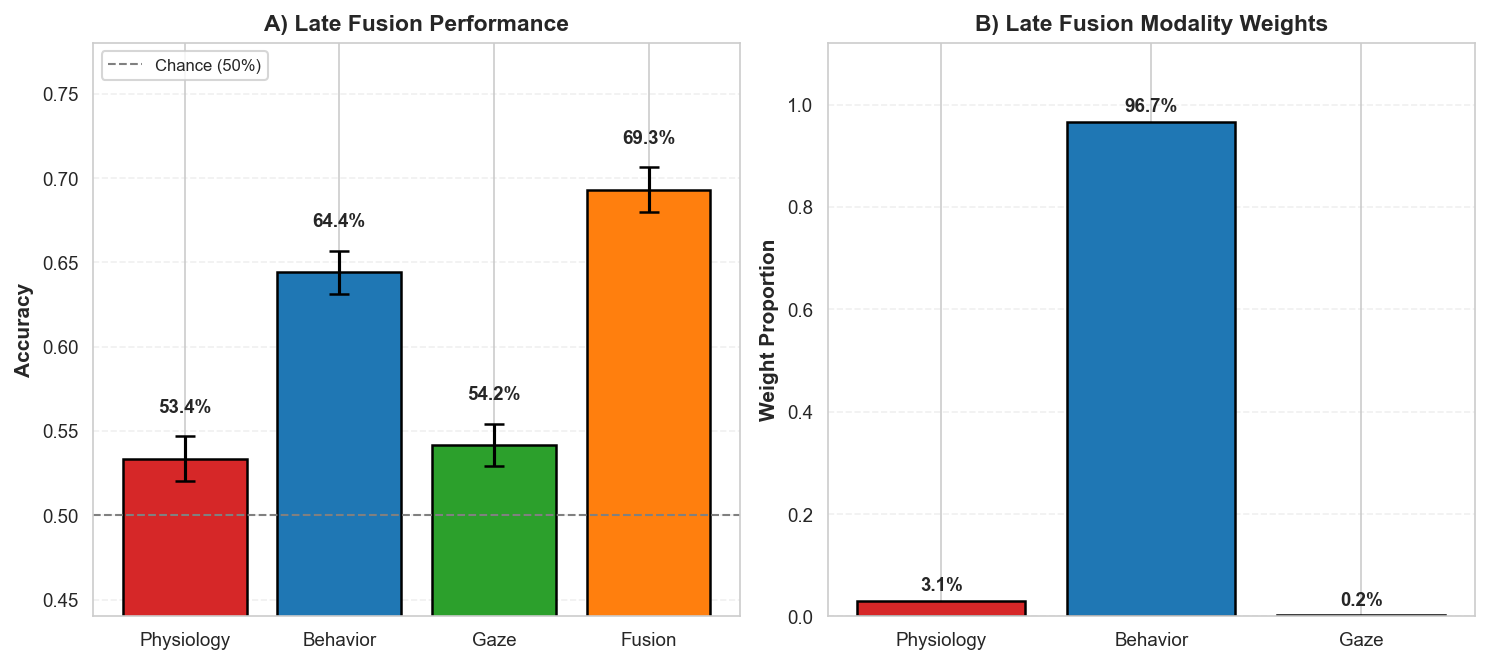


Figure 1. Late fusion model performance for pre-decision prediction of investment
choices (N = 97 participants, 12,511 trials).
(A) Classification accuracy for individual modalities and the weighted late fusion model.
Physiology achieved 53.4% (SEM = 0.013), Behavior 64.4%
(SEM = 0.013), Gaze 54.2% (SEM = 0.012), and Weighted Fusion
69.3% (SEM = 0.013). The dashed line indicates chance level (50%).
Error bars represent SEM computed across 97 leave-one-subject-out cross-validation folds.
Two-sample z-tests for proportions comparing each modality to the fusion model:
Physiology vs. Fusion p = 0.00e+00; Behavior vs. Fusion p = 0.0080;
Gaze vs. Fusion p = 2.22e-16.
(B) Optimized modality weights: Behavior 96.7%, Physiology 3.1%,
Gaze 0.22%.



In [9]:
# ── Figure 1 Plot ──

modalities = ['Physiology', 'Behavior', 'Gaze', 'Fusion']
accs = [accs_physio_subj.mean(), accs_behavior_subj.mean(),
        accs_gaze_subj.mean(), get_acc('Weighted Fusion')]
sems = [stats.sem(accs_physio_subj), stats.sem(accs_behavior_subj),
        stats.sem(accs_gaze_subj), fusion_sem]

# Weighted fusion weights
w_phys = weights_df[weights_df['Modality'] == 'Physiology']['Weighted'].values[0]
w_behav = weights_df[weights_df['Modality'] == 'Behavior']['Weighted'].values[0]
w_gaze = weights_df[weights_df['Modality'] == 'Gaze']['Weighted'].values[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))

# Panel A: Accuracy bars with real SEMs
colors_a = [MOD_COLORS[m] for m in modalities]
bars = ax1.bar(modalities, accs, yerr=sems, capsize=5,
               color=colors_a, edgecolor='black', linewidth=1.2,
               error_kw={'linewidth': 1.5, 'capthick': 1.2})
ax1.axhline(0.5, color='gray', ls='--', lw=1, label='Chance (50%)')
ax1.set_ylabel('Accuracy', fontweight='bold')
ax1.set_ylim(0.44, 0.78)
ax1.set_title('A) Late Fusion Performance', fontweight='bold')
ax1.legend(loc='upper left', frameon=True, fontsize=8)
ax1.grid(axis='y', alpha=0.3, ls='--')

# % on top of each bar
for bar, acc, sem in zip(bars, accs, sems):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + sem + 0.012,
             f'{acc:.1%}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Panel B: Modality weights
weight_mods = ['Physiology', 'Behavior', 'Gaze']
weights_vals = [w_phys, w_behav, w_gaze]
colors_b = [MOD_COLORS[m] for m in weight_mods]
bars2 = ax2.bar(weight_mods, weights_vals, color=colors_b,
                edgecolor='black', linewidth=1.2)
ax2.set_ylabel('Weight Proportion', fontweight='bold')
ax2.set_title('B) Late Fusion Modality Weights', fontweight='bold')
ax2.set_ylim(0, 1.12)
ax2.grid(axis='y', alpha=0.3, ls='--')

for bar, w in zip(bars2, weights_vals):
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
             f'{w*100:.1f}%', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(output_dir / 'figure1_late_fusion_performance.pdf', dpi=300, bbox_inches='tight')
plt.savefig(output_dir / 'figure1_late_fusion_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# ── Stats for caption ──
p_phys_fus = z_test_proportions(accs[0], sems[0], accs[3], sems[3])
p_behav_fus = z_test_proportions(accs[1], sems[1], accs[3], sems[3])
p_gaze_fus = z_test_proportions(accs[2], sems[2], accs[3], sems[3])

caption = f"""
Figure 1. Late fusion model performance for pre-decision prediction of investment
choices (N = {merged_df['subject_id'].nunique()} participants, {len(merged_df):,} trials).
(A) Classification accuracy for individual modalities and the weighted late fusion model.
Physiology achieved {accs[0]:.1%} (SEM = {sems[0]:.3f}), Behavior {accs[1]:.1%}
(SEM = {sems[1]:.3f}), Gaze {accs[2]:.1%} (SEM = {sems[2]:.3f}), and Weighted Fusion
{accs[3]:.1%} (SEM = {sems[3]:.3f}). The dashed line indicates chance level (50%).
Error bars represent SEM computed across 97 leave-one-subject-out cross-validation folds.
Two-sample z-tests for proportions comparing each modality to the fusion model:
Physiology vs. Fusion p = {p_phys_fus:.2e}; Behavior vs. Fusion p = {p_behav_fus:.4f};
Gaze vs. Fusion p = {p_gaze_fus:.2e}.
(B) Optimized modality weights: Behavior {w_behav*100:.1f}%, Physiology {w_phys*100:.1f}%,
Gaze {w_gaze*100:.2f}%.
"""
print(caption)

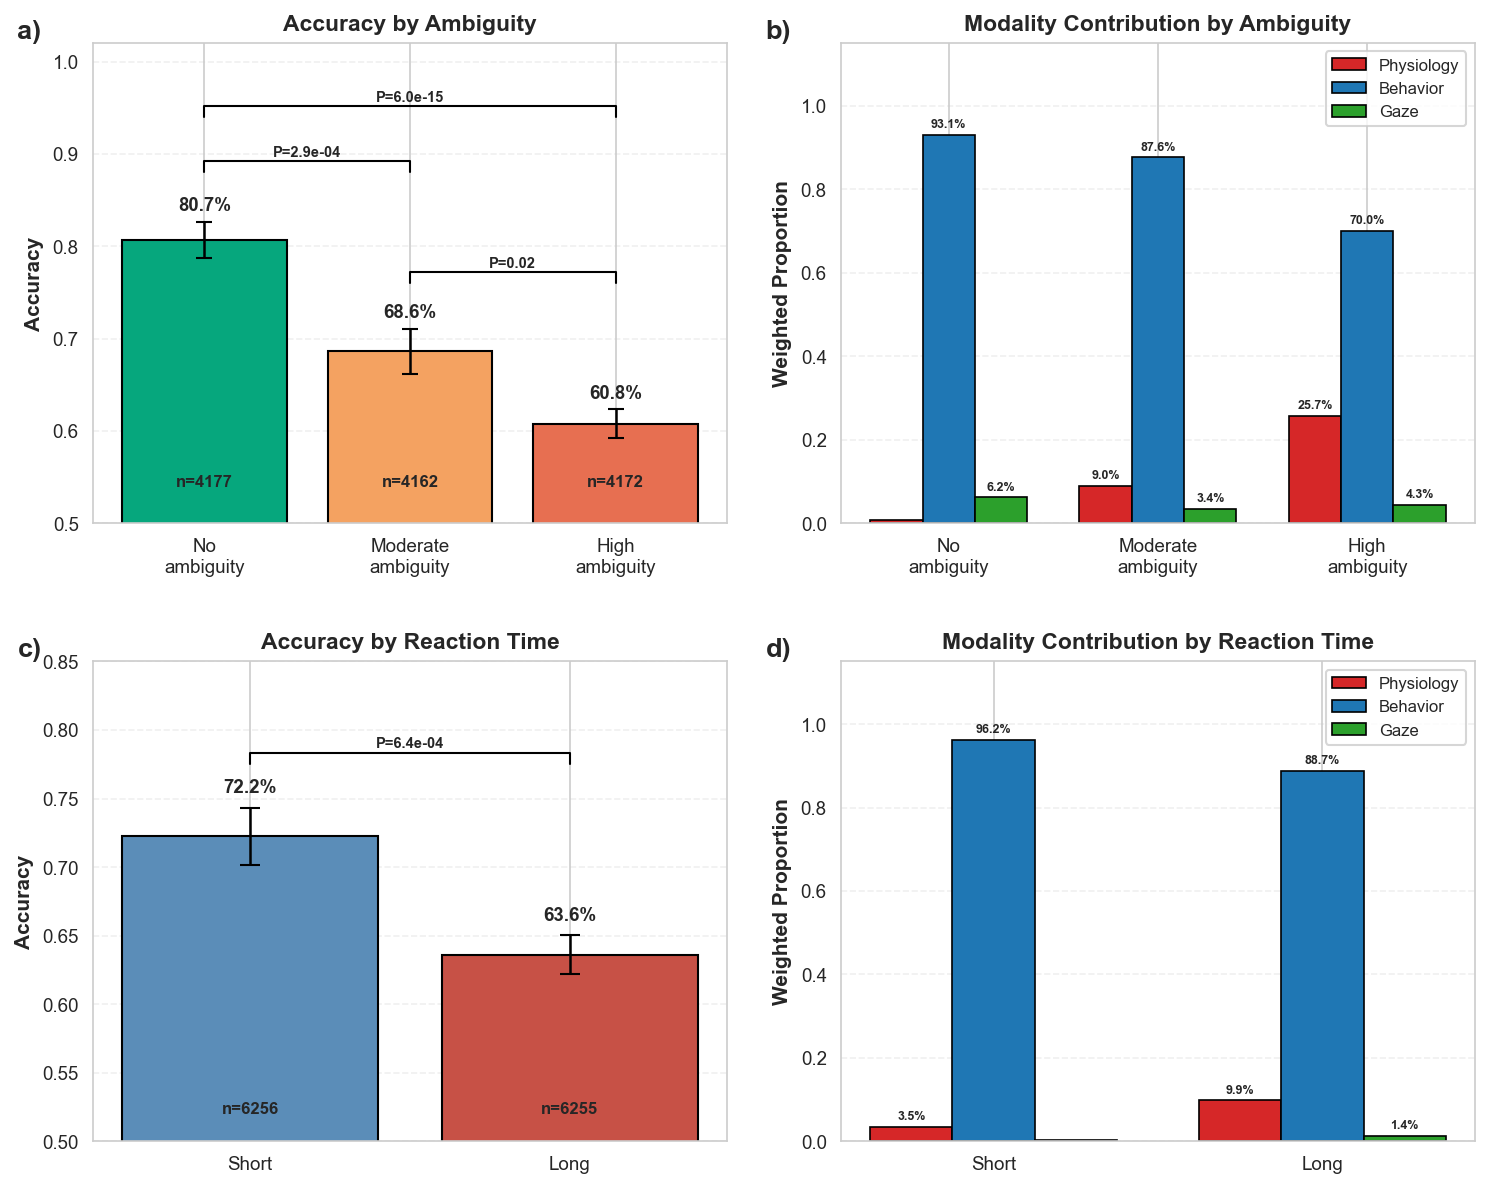


Figure 2. Model accuracy under different ambiguity levels and reaction times.
a) Classification accuracy decreases with increasing ambiguity (No ambiguity: 80.7%,
Moderate ambiguity: 68.6%, High ambiguity: 60.8%).
Error bars represent SEM across leave-one-subject-out cross-validation folds.
Differences assessed using post-hoc z-tests for proportions with Bonferroni correction.
No ambiguity vs. Moderate: P = 2.89e-04;
Moderate vs. High: P = 0.0185;
No ambiguity vs. High: P = 6.00e-15.
b) Fusion weights by ambiguity level show behavioral features dominate, but physiology contribution
increases from 0.7% to 25.7% as ambiguity increases.
c) Decisions made under shorter reaction time (72.2%) are more predictable than
decisions with longer reaction time (63.6%, P = 6.38e-04 by two-sample z-test
for proportions).
d) Physiology contribution increases for decisions with longer reaction time (9.9%)
compared to shorter reaction time (3.5%), while behavioral features
remain dominant in both condi

In [10]:
# ═══════════════════════════════════════════════════════════════════════════════
# FIGURE 2: Ambiguity & Reaction Time (combined 2×2)
# ═══════════════════════════════════════════════════════════════════════════════

# ── Data extraction ──
groups = ['Low', 'Medium', 'High']
amb_accs = [ambiguity_df[ambiguity_df['Group'] == g]['Accuracy'].values[0] for g in groups]
amb_sems = [ambiguity_df[ambiguity_df['Group'] == g]['Accuracy_SEM'].values[0] for g in groups]
amb_n = [int(ambiguity_df[ambiguity_df['Group'] == g]['N_Trials'].values[0]) for g in groups]
amb_phys_w = [ambiguity_df[ambiguity_df['Group'] == g]['Physiology_Weight'].values[0] for g in groups]
amb_behav_w = [ambiguity_df[ambiguity_df['Group'] == g]['Behavior_Weight'].values[0] for g in groups]
amb_gaze_w = [ambiguity_df[ambiguity_df['Group'] == g]['Gaze_Weight'].values[0] for g in groups]

rt_groups_raw = ['Fast', 'Slow']
rt_accs = [rt_df[rt_df['Group'] == g]['Accuracy'].values[0] for g in rt_groups_raw]
rt_sems = [rt_df[rt_df['Group'] == g]['Accuracy_SEM'].values[0] for g in rt_groups_raw]
rt_n = [int(rt_df[rt_df['Group'] == g]['N_Trials'].values[0]) for g in rt_groups_raw]
rt_phys_w = [rt_df[rt_df['Group'] == g]['Physiology_Weight'].values[0] for g in rt_groups_raw]
rt_behav_w = [rt_df[rt_df['Group'] == g]['Behavior_Weight'].values[0] for g in rt_groups_raw]
rt_gaze_w = [rt_df[rt_df['Group'] == g]['Gaze_Weight'].values[0] for g in rt_groups_raw]

# ── Statistics ──
p_lm_raw = z_test_proportions(amb_accs[0], amb_sems[0], amb_accs[1], amb_sems[1])
p_mh_raw = z_test_proportions(amb_accs[1], amb_sems[1], amb_accs[2], amb_sems[2])
p_lh_raw = z_test_proportions(amb_accs[0], amb_sems[0], amb_accs[2], amb_sems[2])
p_lm = min(p_lm_raw * 3, 1.0)
p_mh = min(p_mh_raw * 3, 1.0)
p_lh = min(p_lh_raw * 3, 1.0)

p_rt = z_test_proportions(rt_accs[0], rt_sems[0], rt_accs[1], rt_sems[1])

def fmt_p(p):
    if p < 0.001:
        return f'P={p:.1e}'
    elif p < 0.01:
        return f'P={p:.3f}'
    else:
        return f'P={p:.2f}'

# ── Plot ──
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# ── Panel a: Accuracy by Ambiguity ──
ax = axes[0, 0]
amb_labels = ['No\nambiguity', 'Moderate\nambiguity', 'High\nambiguity']
x_amb = np.arange(len(groups))
amb_bar_colors = [AMB_COLORS['Low'], AMB_COLORS['Medium'], AMB_COLORS['High']]
bars_a = ax.bar(x_amb, amb_accs, yerr=amb_sems, capsize=4,
                color=amb_bar_colors, edgecolor='black', linewidth=1,
                error_kw={'linewidth': 1.2, 'capthick': 1})
ax.set_xticks(x_amb)
ax.set_xticklabels(amb_labels, fontsize=9)
ax.set_ylabel('Accuracy', fontweight='bold')
ax.set_ylim(0.50, 1.02)
ax.set_title('Accuracy by Ambiguity', fontweight='bold', fontsize=11)
ax.grid(axis='y', alpha=0.3, ls='--')

for bar, acc, sem in zip(bars_a, amb_accs, amb_sems):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + sem + 0.008,
            f'{acc:.1%}', ha='center', va='bottom', fontsize=9, fontweight='bold')

for i, n in enumerate(amb_n):
    ax.text(i, 0.54, f'n={n}', ha='center', fontsize=8, fontweight='bold')

def add_bracket(ax, x1, x2, y, text, h=0.012):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], 'k-', lw=1)
    ax.text((x1+x2)/2, y+h+0.002, text, ha='center', va='bottom', fontsize=7, fontweight='bold')

add_bracket(ax, 1, 2, 0.76, fmt_p(p_mh))
add_bracket(ax, 0, 1, 0.88, fmt_p(p_lm))
add_bracket(ax, 0, 2, 0.94, fmt_p(p_lh))

ax.text(-0.12, 1.05, 'a)', transform=ax.transAxes, fontsize=13, fontweight='bold', va='top')

# ── Panel b: Modality weights by Ambiguity (uses MOD_COLORS) ──
ax = axes[0, 1]
bar_w = 0.25
bars_b_phys = ax.bar(x_amb - bar_w, amb_phys_w, bar_w, label='Physiology',
       color=MOD_COLORS['Physiology'], edgecolor='black', linewidth=0.8)
bars_b_behav = ax.bar(x_amb, amb_behav_w, bar_w, label='Behavior',
       color=MOD_COLORS['Behavior'], edgecolor='black', linewidth=0.8)
bars_b_gaze = ax.bar(x_amb + bar_w, amb_gaze_w, bar_w, label='Gaze',
       color=MOD_COLORS['Gaze'], edgecolor='black', linewidth=0.8)
ax.set_xticks(x_amb)
ax.set_xticklabels(amb_labels, fontsize=9)
ax.set_ylabel('Weighted Proportion', fontweight='bold')
ax.set_ylim(0, 1.15)
ax.set_title('Modality Contribution by Ambiguity', fontweight='bold', fontsize=11)
ax.legend(loc='upper right', fontsize=8, frameon=True)
ax.grid(axis='y', alpha=0.3, ls='--')

# % on top of each bar in panel b
for bars in [bars_b_phys, bars_b_behav, bars_b_gaze]:
    for bar in bars:
        h = bar.get_height()
        if h > 0.01:
            ax.text(bar.get_x() + bar.get_width() / 2, h + 0.01,
                    f'{h*100:.1f}%', ha='center', va='bottom', fontsize=6, fontweight='bold')

ax.text(-0.12, 1.05, 'b)', transform=ax.transAxes, fontsize=13, fontweight='bold', va='top')

# ── Panel c: Accuracy by Reaction Time ──
ax = axes[1, 0]
rt_labels = ['Short', 'Long']
x_rt = np.arange(len(rt_groups_raw))
rt_bar_colors = [RT_COLORS['Fast'], RT_COLORS['Slow']]
bars_c = ax.bar(x_rt, rt_accs, yerr=rt_sems, capsize=5,
                color=rt_bar_colors, edgecolor='black', linewidth=1,
                error_kw={'linewidth': 1.2, 'capthick': 1})
ax.set_xticks(x_rt)
ax.set_xticklabels(rt_labels, fontsize=9)
ax.set_ylabel('Accuracy', fontweight='bold')
ax.set_ylim(0.50, 0.85)
ax.set_title('Accuracy by Reaction Time', fontweight='bold', fontsize=11)
ax.grid(axis='y', alpha=0.3, ls='--')

for bar, acc, sem in zip(bars_c, rt_accs, rt_sems):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + sem + 0.008,
            f'{acc:.1%}', ha='center', va='bottom', fontsize=9, fontweight='bold')

for i, n in enumerate(rt_n):
    ax.text(i, 0.52, f'n={n}', ha='center', fontsize=8, fontweight='bold')

y_sig = max(rt_accs) + max(rt_sems) + 0.04
ax.plot([0, 0, 1, 1], [y_sig-0.008, y_sig, y_sig, y_sig-0.008], 'k-', lw=1)
ax.text(0.5, y_sig+0.002, fmt_p(p_rt), ha='center', va='bottom', fontsize=7, fontweight='bold')

ax.text(-0.12, 1.05, 'c)', transform=ax.transAxes, fontsize=13, fontweight='bold', va='top')

# ── Panel d: Modality weights by RT (uses MOD_COLORS) ──
ax = axes[1, 1]
bars_d_phys = ax.bar(x_rt - bar_w, rt_phys_w, bar_w, label='Physiology',
       color=MOD_COLORS['Physiology'], edgecolor='black', linewidth=0.8)
bars_d_behav = ax.bar(x_rt, rt_behav_w, bar_w, label='Behavior',
       color=MOD_COLORS['Behavior'], edgecolor='black', linewidth=0.8)
bars_d_gaze = ax.bar(x_rt + bar_w, rt_gaze_w, bar_w, label='Gaze',
       color=MOD_COLORS['Gaze'], edgecolor='black', linewidth=0.8)
ax.set_xticks(x_rt)
ax.set_xticklabels(rt_labels, fontsize=9)
ax.set_ylabel('Weighted Proportion', fontweight='bold')
ax.set_ylim(0, 1.15)
ax.set_title('Modality Contribution by Reaction Time', fontweight='bold', fontsize=11)
ax.legend(loc='upper right', fontsize=8, frameon=True)
ax.grid(axis='y', alpha=0.3, ls='--')

# % on top of each bar in panel d
for bars in [bars_d_phys, bars_d_behav, bars_d_gaze]:
    for bar in bars:
        h = bar.get_height()
        if h > 0.01:
            ax.text(bar.get_x() + bar.get_width() / 2, h + 0.01,
                    f'{h*100:.1f}%', ha='center', va='bottom', fontsize=6, fontweight='bold')

ax.text(-0.12, 1.05, 'd)', transform=ax.transAxes, fontsize=13, fontweight='bold', va='top')

plt.tight_layout(h_pad=3.0, w_pad=2.5)
plt.savefig(output_dir / 'figure2_ambiguity_rt_combined.pdf', dpi=300, bbox_inches='tight')
plt.savefig(output_dir / 'figure2_ambiguity_rt_combined.png', dpi=300, bbox_inches='tight')
plt.show()

# ── Caption ──
caption2 = f"""
Figure 2. Model accuracy under different ambiguity levels and reaction times.
a) Classification accuracy decreases with increasing ambiguity (No ambiguity: {amb_accs[0]:.1%},
Moderate ambiguity: {amb_accs[1]:.1%}, High ambiguity: {amb_accs[2]:.1%}).
Error bars represent SEM across leave-one-subject-out cross-validation folds.
Differences assessed using post-hoc z-tests for proportions with Bonferroni correction.
No ambiguity vs. Moderate: P = {p_lm:.2e};
Moderate vs. High: P = {p_mh:.4f};
No ambiguity vs. High: P = {p_lh:.2e}.
b) Fusion weights by ambiguity level show behavioral features dominate, but physiology contribution
increases from {amb_phys_w[0]*100:.1f}% to {amb_phys_w[2]*100:.1f}% as ambiguity increases.
c) Decisions made under shorter reaction time ({rt_accs[0]:.1%}) are more predictable than
decisions with longer reaction time ({rt_accs[1]:.1%}, P = {p_rt:.2e} by two-sample z-test
for proportions).
d) Physiology contribution increases for decisions with longer reaction time ({rt_phys_w[1]*100:.1f}%)
compared to shorter reaction time ({rt_phys_w[0]*100:.1f}%), while behavioral features
remain dominant in both conditions.
"""
print(caption2)

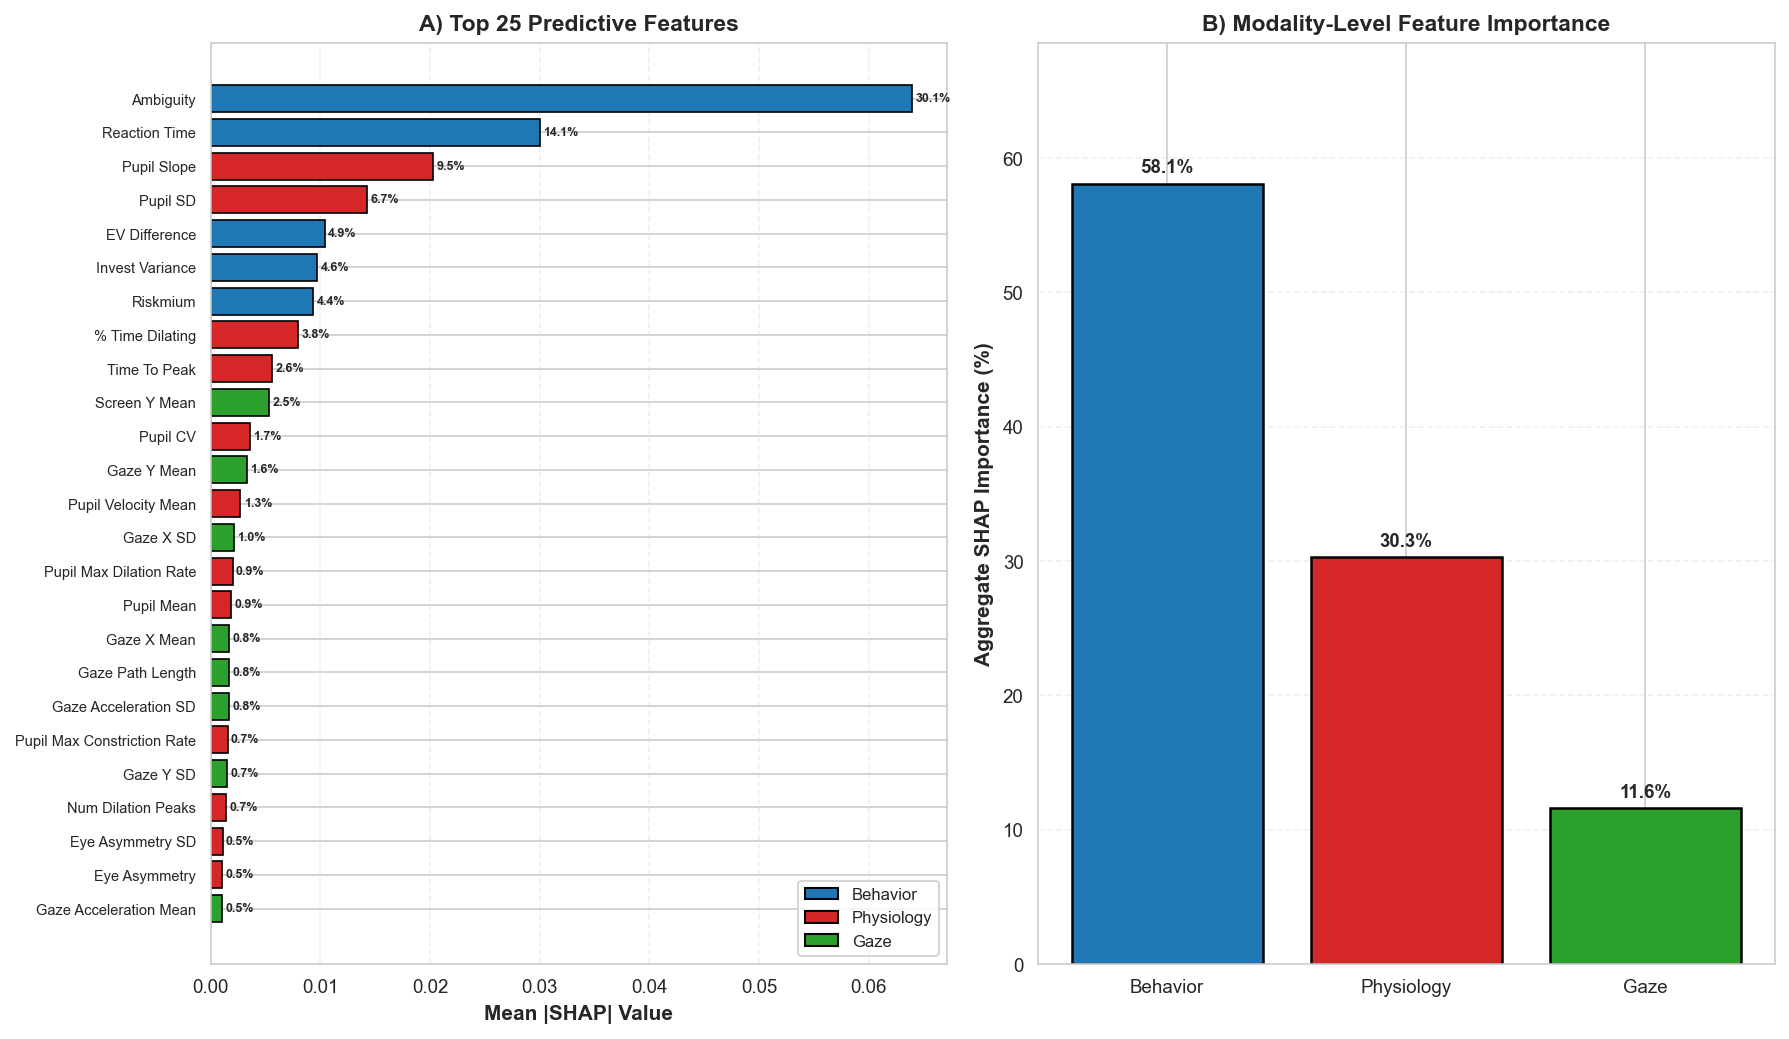


Figure 3. Feature importance analysis using SHAP (SHapley Additive exPlanations) values.
(A) Top 25 features ranked by mean absolute SHAP value. The three most important features
were Ambiguity (30.1%), Reaction Time (14.1%), Pupil Slope (9.5%). Features are color-coded by modality. Percentages indicate each feature's
share of total SHAP importance. (B) Aggregate SHAP importance by modality:
Behavior 58.1%, Physiology 30.3%,
Gaze 11.6%. SHAP values were computed from a gradient-boosted
classifier trained on all features with leave-one-subject-out cross-validation.
No error bars are shown as SHAP values represent deterministic feature attributions
from the trained model.

Feature glossary:
  - Ambiguity: trial ambiguity level (0/3/6 hidden outcomes)
  - Reaction Time: time from stimulus onset to button press
  - Pupil Slope: slope of pupil diameter in pre-decision window
  - Pupil SD: standard deviation of pupil diameter pre-decision
  - EV Difference: expected value difference between

In [11]:
# ═══════════════════════════════════════════════════════════════════════════════
# FIGURE 3: Feature Importance Analysis (SHAP) — Top 25
# ═══════════════════════════════════════════════════════════════════════════════

# Feature descriptions for caption
FEATURE_DESCRIPTIONS = {
    'ambiguity': 'trial ambiguity level (0/3/6 hidden outcomes)',
    'reaction_time': 'time from stimulus onset to button press',
    'pupil_slope_pre': 'slope of pupil diameter in pre-decision window',
    'pupil_std_pre': 'standard deviation of pupil diameter pre-decision',
    'ev_difference': 'expected value difference between invest and keep options',
    'invest_variance': 'variance of the investment option payoff',
    'risk_premium': 'difference between EV and certainty equivalent',
    'pct_time_dilating_pre': 'percentage of pre-decision time with pupil dilation',
    'time_to_peak_pre': 'time to peak pupil dilation pre-decision',
    'screen_y_mean': 'mean vertical screen-space gaze coordinate',
    'pupil_cv_pre': 'coefficient of variation of pupil diameter pre-decision',
    'gaze_y_mean': 'mean vertical gaze position (head-referenced)',
    'pupil_velocity_mean_pre': 'mean pupil constriction/dilation velocity pre-decision',
    'gaze_x_std': 'horizontal gaze position variability',
    'pupil_max_dilation_rate_pre': 'maximum pupil dilation rate pre-decision',
    'pupil_mean_pre': 'mean pupil diameter pre-decision',
    'gaze_x_mean': 'mean horizontal gaze position',
    'gaze_path_length': 'total Euclidean distance traversed by gaze',
    'gaze_acceleration_std': 'variability of gaze acceleration',
    'pupil_max_constriction_rate_pre': 'maximum pupil constriction rate pre-decision',
    'gaze_y_std': 'vertical gaze position variability',
    'num_dilation_peaks_pre': 'number of pupil dilation peaks pre-decision',
    'eye_asymmetry_std_pre': 'variability of left-right pupil asymmetry pre-decision',
    'eye_asymmetry_pre': 'mean left-right pupil size asymmetry pre-decision',
    'gaze_acceleration_mean': 'mean gaze acceleration',
}

# Classify features by modality
behavior_features = {'ambiguity', 'reaction_time', 'decision_time', 'invest_variance',
                     'ev_difference', 'risk_premium', 'previous_outcome'}
physio_features = set(physio_cols)

def get_modality(feat):
    if feat in behavior_features or feat in behavior_cols:
        return 'Behavior'
    elif feat in physio_features or feat in physio_cols:
        return 'Physiology'
    else:
        return 'Gaze'

shap_df['modality'] = shap_df['feature'].apply(get_modality)

# Top 25
top25 = shap_df.head(25).copy()
top25_colors = [MOD_COLORS[m] for m in top25['modality']]

# Clean feature names for axis labels
def clean_name(n):
    return (n.replace('_pre', '').replace('_', ' ').replace('pct ', '% ')
             .title().replace('Ev ', 'EV ').replace('Std', 'SD').replace('Cv', 'CV'))

top25['clean'] = top25['feature'].apply(clean_name)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

# Panel A: Top 25 SHAP features
y_pos = np.arange(len(top25))
ax1.barh(y_pos, top25['mean_abs_shap'].values, color=top25_colors,
         edgecolor='black', linewidth=0.8)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(top25['clean'].values, fontsize=7)
ax1.invert_yaxis()
ax1.set_xlabel('Mean |SHAP| Value', fontweight='bold')
ax1.set_title('A) Top 25 Predictive Features', fontweight='bold')
ax1.grid(axis='x', alpha=0.3, ls='--')

# % labels on bars (proportion of total SHAP)
total_shap = shap_df['mean_abs_shap'].sum()
for i, val in enumerate(top25['mean_abs_shap'].values):
    ax1.text(val + 0.0003, i, f'{val/total_shap*100:.1f}%', va='center', fontsize=6, fontweight='bold')

legend_elements = [Patch(facecolor=MOD_COLORS['Behavior'], edgecolor='black', label='Behavior'),
                   Patch(facecolor=MOD_COLORS['Physiology'], edgecolor='black', label='Physiology'),
                   Patch(facecolor=MOD_COLORS['Gaze'], edgecolor='black', label='Gaze')]
ax1.legend(handles=legend_elements, loc='lower right', fontsize=8)

# Panel B: Aggregate SHAP by modality
mod_shap = shap_df.groupby('modality')['mean_abs_shap'].sum()
mod_total = mod_shap.sum()
mod_pct = (mod_shap / mod_total * 100).to_dict()

mod_order = ['Behavior', 'Physiology', 'Gaze']
mod_vals = [mod_pct.get(m, 0) for m in mod_order]
mod_cols = [MOD_COLORS[m] for m in mod_order]

bars2 = ax2.bar(mod_order, mod_vals, color=mod_cols, edgecolor='black', linewidth=1.2)
ax2.set_ylabel('Aggregate SHAP Importance (%)', fontweight='bold')
ax2.set_title('B) Modality-Level Feature Importance', fontweight='bold')
ax2.set_ylim(0, max(mod_vals) * 1.18)
ax2.grid(axis='y', alpha=0.3, ls='--')

for bar, v in zip(bars2, mod_vals):
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.8,
             f'{v:.1f}%', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(output_dir / 'figure3_feature_importance.pdf', dpi=300, bbox_inches='tight')
plt.savefig(output_dir / 'figure3_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# ── Caption ──
top3 = top25.head(3)
top3_str = ', '.join([f'{r["clean"]} ({r["mean_abs_shap"]/total_shap*100:.1f}%)'
                      for _, r in top3.iterrows()])

# Build feature glossary for secondary caption
feat_glossary = '\n'.join([f'  - {clean_name(row["feature"])}: {FEATURE_DESCRIPTIONS.get(row["feature"], "")}'
                           for _, row in top25.iterrows()
                           if row['feature'] in FEATURE_DESCRIPTIONS])

caption3 = f"""
Figure 3. Feature importance analysis using SHAP (SHapley Additive exPlanations) values.
(A) Top 25 features ranked by mean absolute SHAP value. The three most important features
were {top3_str}. Features are color-coded by modality. Percentages indicate each feature's
share of total SHAP importance. (B) Aggregate SHAP importance by modality:
Behavior {mod_pct.get('Behavior',0):.1f}%, Physiology {mod_pct.get('Physiology',0):.1f}%,
Gaze {mod_pct.get('Gaze',0):.1f}%. SHAP values were computed from a gradient-boosted
classifier trained on all features with leave-one-subject-out cross-validation.
No error bars are shown as SHAP values represent deterministic feature attributions
from the trained model.

Feature glossary:
{feat_glossary}
"""
print(caption3)